In [ ]:
!pip install ratelim

# import Section

In [ ]:
import pandas as pd
import re
import ratelim

import requests
from bs4 import BeautifulSoup as bs
from tqdm import tqdm

# constant Section

In [ ]:
mainUrl = 'https://habr.com/ru/post/'
postCount = 10000
habrParse_df = pd.DataFrame(columns=['num', 'URL', 'Title', 'Post', 'numComment', 
                                     'Rating', 'Rating_UpVote', 'Rating_DownVote',
                                     'bookMark_count', 'views_count', 'tags', 'hubs'])

# code Section

In [ ]:
def executePost(page):
  soup = bs(page.text, 'html.parser')

  # Получаем заголовок статьи
  title = soup.find('meta', property='og:title')
  title = str(title).split('="')[1].split('" ')[0]
  # -------------------------

  # Получаем текст статьи
  post = str(soup.find('div', id="post-content-body"))
  post = re.sub('\n', ' ', post)
  post = re.sub('\r', ' ', post)
  post = re.sub('<br/>', ' ', post)
  post = re.sub('<b>', ' ', post)
  post = re.sub('</b>', ' ', post)
  post = re.sub('<i>', ' ', post)
  post = re.sub('</i>', ' ', post)
  post = re.sub('<strong>', ' ', post)
  post = re.sub('</strong>', ' ', post)
  post = re.sub('\s+', ' ', post)
  post = re.sub('<a href=.+?">', '', post)
  post = re.sub('<a class=""user_link"" href=".+?">', '', post)
  post = re.sub('<img.+?>', '', post)
  post = re.sub('<.img>', '', post)
  post = re.sub('</a>', '', post)
  post = post.strip()
  post = post.split('id="post-content-body">')[1].split('</div>')[0]
  # -------------------------

  # Получаем количество комментариев
  num_comment = soup.find('span', id='comments_count').text
  num_comment = int(re.sub('\n', '', num_comment).strip())
  # -------------------------

  # Ищем инфо-панель и передаем ее в переменную
  info_panel = soup.find('ul', attrs={'class' : 'post-stats post-stats_post js-user_'})

  # Получаем рейтинг поста
  try:
    #rating = int(soup.find('span', attrs={'class' : 'voting-wjt__counter js-score'}).text)
    rating = int(info_panel.find('span', attrs={'class' : 'voting-wjt__counter js-score'}).text)
  except:
    #rating = soup.find('span', attrs={'class' : 'voting-wjt__counter voting-wjt__counter_positive js-score'})
    rating = info_panel.find('span', attrs={'class' : 'voting-wjt__counter voting-wjt__counter_positive js-score'})
    if rating:
      rating = int(re.sub('/+', '', rating.text))
    else:
      #rating = soup.find('span', attrs={'class' : 'voting-wjt__counter voting-wjt__counter_negative js-score'}).text
      rating = info_panel.find('span', attrs={'class' : 'voting-wjt__counter voting-wjt__counter_negative js-score'}).text
      rating = - int(re.sub('–', '', rating))
  # -------------------------

  # Получаем количество положительных и отрицательных голосов за рейтинг статьи
  vote = info_panel.find_all('span')[0].attrs['title']
  rating_upVote = int(vote.split(':')[1].split('и')[0].strip().split('↑')[1])
  rating_downVote = int(vote.split(':')[1].split('и')[1].strip().split('↓')[1])

  # Получаем количество добавлений в закладки
  bookmk = int(info_panel.find_all('span')[1].text)

  # Получаем количество просмотров поста
  views = info_panel.find_all('span')[3].text

  try:
    tags = list()
    tags_list = soup.find('ul', attrs={'class' : 'inline-list inline-list_fav-tags js-post-tags'}).find_all('li', attrs={'class' : 'inline-list__item inline-list__item_tag'})
    for tag in tags_list:
      tags.append(tag.text)
  except:
    tags = ''

  try:
    hubs = list()
    hubs_list = soup.find('ul', attrs={'class' : 'inline-list inline-list_fav-tags js-post-hubs'}).find_all('li', attrs={'class' : 'inline-list__item inline-list__item_tag'})
    for hub in hubs_list:
      hubs.append(hub.text.strip())
  except:
    hubs = ''

  return title, post, num_comment, rating, rating_upVote, rating_downVote, bookmk, views, tags, hubs

In [ ]:
@ratelim.patient(3, 1)
def get_post(postNum):
  currPostUrl = mainUrl + str(postNum)

  try:
    response = requests.get(currPostUrl)
    response.raise_for_status()

    # Отправляем полученную страницу на обработку
    response_title, response_post, response_numComment, response_rating, response_ratingUp, response_ratingDown, response_bookMark, response_views, response_tags, response_hubs = executePost(response)

    # Записываем данные в DataFrame
    dataList = [postNum, currPostUrl, response_title, response_post, response_numComment, 
                response_rating, response_ratingUp, response_ratingDown, response_bookMark, response_views,
                response_tags, response_hubs]
    habrParse_df.loc[len(habrParse_df)] = dataList

  except requests.exceptions.HTTPError as err:
    pass

In [ ]:
for pc in tqdm(range(postCount)):
  postNum = pc + 1
  get_post(postNum)

100%|██████████| 10000/10000 [4:12:32<00:00,  1.52s/it]


In [ ]:
habrParse_df['num'] = habrParse_df['num'].astype(int)
habrParse_df['numComment'] = habrParse_df['numComment'].astype(int)
habrParse_df['Rating'] = habrParse_df['Rating'].astype(int)
habrParse_df['Rating_UpVote'] = habrParse_df['Rating_UpVote'].astype(int)
habrParse_df['Rating_DownVote'] = habrParse_df['Rating_DownVote'].astype(int)
habrParse_df['bookMark_count'] = habrParse_df['bookMark_count'].astype(int)

In [ ]:
habrParse_df.head()

,num,URL,Title,Post,numComment,Rating,Rating_UpVote,Rating_DownVote,bookMark_count,views_count,tags,hubs
0,1,https://habr.com/ru/post/1,Wiki-FAQ для Хабрахабра,Привет! Для сборника ответов на Часто Задаваем...,62,1,1,0,8,"30,7k","[хабрахаб, wiki, FAQ, ЧАВО, механизм, движок]",[Habr]
1,2,https://habr.com/ru/post/2,Мы знаем много недоделок на сайте… но!,"Кроме неработающих и отсутствующих страниц, о ...",37,0,0,0,1,"15,8k","[ошибки, баги, bugs, error, warning]",[Habr]
2,3,https://habr.com/ru/post/3,Чтение RSS-потоков,Какими службами пользуетесь для чтения RSS-пот...,21,1,1,0,0,"7,5k",[RSS],[Управление медиа]
3,4,https://habr.com/ru/post/4,"Маслов, Сокур и партнеры пиарят Google в России","Насколько я знаю, Google выбрал агентство «Мас...",15,1,1,0,1,"3,2k","[Google, Маслов, Сокур и партнеры, PR, сопрово...",[Чулан]
4,6,https://habr.com/ru/post/6,Подкасты на Хабрахабре,Мы планируем добавить в раздел «тексты» возмож...,35,0,1,1,1,"3,6k","[хабрахабр, подкасты, mp3, контент, тексты]",[Habr]


In [ ]:
habrParse_df.shape

(8229, 12)

In [ ]:
habrParse_df['post_length'] = habrParse_df['Post'].map(lambda x: len(x.split(' ')))

In [ ]:
habrParse_df.to_csv('habrParse_df_.csv')

In [ ]:
habrParse_df.describe()

,num,numComment,Rating,Rating_UpVote,Rating_DownVote,bookMark_count,post_length
count,8229.000000,8229.000000,8229.000000,8229.000000,8229.000000,8229.000000,8229.000000
mean,4659.371127,15.337100,7.308786,10.374408,3.065622,1.988091,194.954916
std,2777.875359,28.243728,12.152973,13.024002,4.103613,9.526380,295.396454
min,1.000000,0.000000,-34.000000,0.000000,0.000000,0.000000,1.000000
25%,2255.000000,2.000000,0.000000,2.000000,0.000000,0.000000,61.000000
50%,4526.000000,6.000000,4.000000,6.000000,2.000000,0.000000,109.000000
75%,7004.000000,18.000000,11.000000,14.000000,4.000000,1.000000,239.000000
max,9893.000000,598.000000,139.000000,141.000000,73.000000,583.000000,7092.000000


In [ ]:
hubs = list()
hubs_list = soup.find('ul', attrs={'class' : 'inline-list inline-list_fav-tags js-post-hubs'}).find_all('li', attrs={'class' : 'inline-list__item inline-list__item_tag'})
for hub in hubs_list:
  hubs.append(hub.text.strip())
print(hubs)

['Открытые данные', 'Визуализация данных', 'Научно-популярное', 'Биотехнологии', 'Здоровье гика']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
habrParse_df = pd.read_csv('/content/drive/My Drive/HabrParse/habrParse_df_.csv', usecols=['Post', 'hubs'])

In [ ]:
habrParse_df.head()

,Post,hubs
0,Привет! Для сборника ответов на Часто Задаваем...,['Habr']
1,"Кроме неработающих и отсутствующих страниц, о ...",['Habr']
2,Какими службами пользуетесь для чтения RSS-пот...,['Управление медиа']
3,"Насколько я знаю, Google выбрал агентство «Мас...",['Чулан']
4,Мы планируем добавить в раздел «тексты» возмож...,['Habr']


In [ ]:
habrParse_df = habrParse_df.astype({"Post": str})

In [ ]:
habrParse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8229 entries, 0 to 8228
Data columns (total 2 columns):
Post    8229 non-null object
hubs    8229 non-null object
dtypes: object(2)
memory usage: 128.7+ KB


In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

In [ ]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

In [ ]:
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

In [ ]:
corpus = get_corpus(habrParse_df['Post'].values)
procWordCloud = get_wordCloud(corpus)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


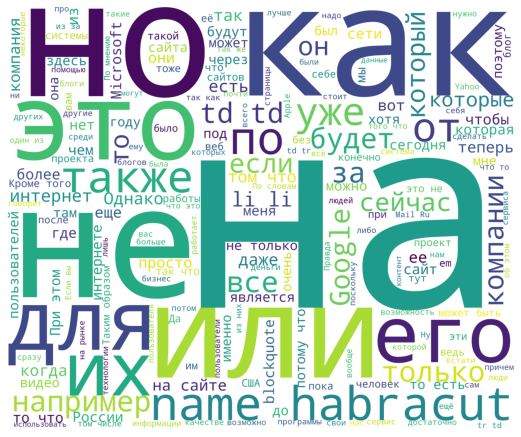

In [ ]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1, 2, 1)

In [ ]:
# Количество уникальных слов в тексте
num_words = len(set(corpus))
num_words

243025

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
from string import punctuation

In [ ]:
russian_stopwords = stopwords.words("russian")

In [ ]:
# Удаление знаков пунктуации из текста
def remove_punct(text):
    #table = str.maketrans('', '', string.punctuation)
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

In [ ]:
habrParse_df['Post_clean'] = habrParse_df['Post'].map(lambda x: x.lower())

In [ ]:
habrParse_df['Post_clean'] = habrParse_df['Post_clean'].map(lambda x: remove_punct(x))

In [ ]:
habrParse_df['Post_clean'] = habrParse_df['Post_clean'].map(lambda x: x.split(' '))

In [ ]:
habrParse_df['Post_clean'] = habrParse_df['Post_clean'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])

In [ ]:
habrParse_df['Post_clean'] = habrParse_df['Post_clean'].map(lambda x: ' '.join(x))

In [ ]:
habrParse_df.head()

,Post,hubs,Post_clean
0,Привет! Для сборника ответов на Часто Задаваем...,['Habr'],привет сборника ответов часто задаваемые вопро...
1,"Кроме неработающих и отсутствующих страниц, о ...",['Habr'],кроме неработающих отсутствующих страниц котор...
2,Какими службами пользуетесь для чтения RSS-пот...,['Управление медиа'],какими службами пользуетесь чтения rss потоков...
3,"Насколько я знаю, Google выбрал агентство «Мас...",['Чулан'],насколько знаю google выбрал агентство «маслов...
4,Мы планируем добавить в раздел «тексты» возмож...,['Habr'],планируем добавить раздел «тексты» возможность...


In [ ]:
corpus_clean = get_corpus(habrParse_df['Post_clean'].values)
procWordCloud = get_wordCloud(corpus_clean)

In [ ]:
# Количество уникальных слов в тексте
num_words = len(set(corpus_clean))
num_words

142254

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


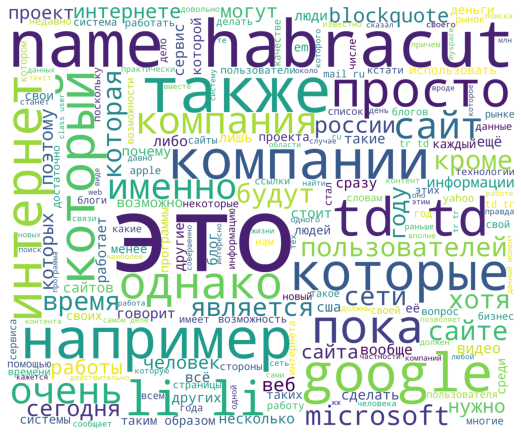

In [ ]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1, 2, 1)

In [ ]:
df_habr = habrParse_df[['Post_clean', 'hubs']]

In [ ]:
from ast import literal_eval

In [ ]:
df_habr['hubs'] = df_habr['hubs'].map(lambda x: literal_eval(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_habr.head()

,Post_clean,hubs
0,привет сборника ответов часто задаваемые вопро...,[Habr]
1,кроме неработающих отсутствующих страниц котор...,[Habr]
2,какими службами пользуетесь чтения rss потоков...,[Управление медиа]
3,насколько знаю google выбрал агентство «маслов...,[Чулан]
4,планируем добавить раздел «тексты» возможность...,[Habr]


In [ ]:
df_habr['hubs'] = df_habr['hubs'].map(lambda x: x[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_habr.head()

,Post_clean,hubs
0,привет сборника ответов часто задаваемые вопро...,Habr
1,кроме неработающих отсутствующих страниц котор...,Habr
2,какими службами пользуетесь чтения rss потоков...,Управление медиа
3,насколько знаю google выбрал агентство «маслов...,Чулан
4,планируем добавить раздел «тексты» возможность...,Habr


In [ ]:
p = pd.DataFrame(df_habr['hubs'].value_counts())
p

,hubs
Чулан,5370
IT-компании,722
Habr,566
Управление медиа,165
Я пиарюсь,125
...,...
Биотехнологии,1
Занимательные задачки,1
Emacs,1
Типографика,1


In [ ]:
p = p.loc[p['hubs'] > 100]
p

,hubs
Чулан,5370
IT-компании,722
Habr,566
Управление медиа,165
Я пиарюсь,125


In [ ]:
df_habr_clean = df_habr.loc[df_habr['hubs'].isin(['IT-компании', 'Habr', 'Управление медиа', 'Я пиарюсь'])]

In [ ]:
df_habr_clean.head()

,Post_clean,hubs
0,привет сборника ответов часто задаваемые вопро...,Habr
1,кроме неработающих отсутствующих страниц котор...,Habr
2,какими службами пользуетесь чтения rss потоков...,Управление медиа
4,планируем добавить раздел «тексты» возможность...,Habr
5,такое ощущение logout время времени происходит...,Habr


In [ ]:
df_habr_clean.shape

(1578, 2)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df_habr_clean['Post_clean'], df_habr_clean['hubs'], test_size=0.1, random_state=42)

In [ ]:
X_train.shape

(1420,)

In [ ]:
X_valid.shape

(158,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(1136,)

In [ ]:
X_test.shape

(284,)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))
])

In [ ]:
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=4))
])

In [ ]:
sgd_ppl_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                ('sgd_clf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal

In [ ]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

                  precision    recall  f1-score   support

            Habr       0.90      0.86      0.88        94
     IT-компании       0.95      0.83      0.89       153
Управление медиа       0.67      0.96      0.79        23
       Я пиарюсь       0.41      0.79      0.54        14

        accuracy                           0.85       284
       macro avg       0.73      0.86      0.77       284
    weighted avg       0.88      0.85      0.86       284



In [ ]:
parameters = { 
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,2), (1,3), (1,4)]
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train, y_train)

In [ ]:
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_) 

Best score and parameter combination:
0.8565140845070423 {'sgd_clf__class_weight': 'balanced', 'sgd_clf__loss': 'hinge', 'sgd_clf__penalty': 'elasticnet', 'tfidf__ngram_range': (1, 4), 'tfidf__strip_accents': 'unicode'}


In [ ]:
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_) 

Best score and parameter combination:
0.852112676056338 {'sgd_clf__class_weight': 'balanced', 'sgd_clf__loss': 'hinge', 'sgd_clf__penalty': 'elasticnet', 'tfidf__ngram_range': (1, 2), 'tfidf__strip_accents': None}


In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), strip_accents='unicode')),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=42))
])

In [ ]:
sgd_ppl_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents='unicode',
                                 sublinear_tf=False,
                                 token_patt...
                 SGDClassifier(alpha=0.0001, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                   

In [ ]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

                  precision    recall  f1-score   support

            Habr       0.89      0.90      0.89        89
     IT-компании       0.93      0.91      0.92       136
Управление медиа       0.82      0.71      0.76        38
       Я пиарюсь       0.59      0.76      0.67        21

        accuracy                           0.87       284
       macro avg       0.81      0.82      0.81       284
    weighted avg       0.87      0.87      0.87       284



In [ ]:
knb_ppl_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('knb_clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=N

In [ ]:
predicted_sgd = knb_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

                  precision    recall  f1-score   support

            Habr       0.82      0.80      0.81        92
     IT-компании       0.90      0.77      0.83       155
Управление медиа       0.48      0.89      0.63        18
       Я пиарюсь       0.26      0.37      0.30        19

        accuracy                           0.76       284
       macro avg       0.62      0.71      0.64       284
    weighted avg       0.80      0.76      0.78       284



In [ ]:
predicted_sgd_val = sgd_ppl_clf.predict(X_valid)
print(metrics.classification_report(predicted_sgd_val, y_valid))

                  precision    recall  f1-score   support

            Habr       0.93      0.93      0.93        57
     IT-компании       0.89      0.93      0.91        71
Управление медиа       0.71      0.52      0.60        23
       Я пиарюсь       0.60      0.86      0.71         7

        accuracy                           0.87       158
       macro avg       0.78      0.81      0.79       158
    weighted avg       0.87      0.87      0.86       158

